# ANOVA and the completely randomised design

## 1. Introduction

The completely randomised design is often used to compare the effect of some factors when experimental conditions are uniform. Each factor is applied at random to several experimental units. Randomisation ensures there is no subjectivity in the allocation of factors to units and that the effect of other factors cancel out when factor means are compared.

The advantages of the completely randomised design are:
* the number of replications need not be the same for each factor
* the degrees of freedom are maximised (no other design provides greater degrees of freedom)

But there are also a big disadvantage:
* low precision if experimental units subject to the same factor are not uniform, which will increase withing-factor variance and factor differences will be difficult to detect

The independent samples t-test can be used to analyse the results of a completely randomised design when there are two factors. When there are more than two (categorical) factors **one-way analysis of variance** (ANOVA) is used. If the factors are numerical, linear regression is used. One-way ANOVA compares the between-treatment variation with the within-treatment variation and assesses whether the differences in the means are due to chance or treatment effects.

## 2. Example

An experiment is carried out to compare four wheat varieties (A, B, C and D). A completely randomised design is used, each variety is assigned to five plots and yields (kg/plot) are measured.

In [2]:
#import useful modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f
from scipy.stats import levene
from scipy.stats import t
from itertools import combinations

#yields
df = pd.DataFrame({'A':[22.2, 17.3, 21.2, 25.2, 16.1],
                  'B':[24.1, 30.3, 27.4, 26.4, 34.8],
                  'C':[25.9, 18.4, 23.2, 21.9, 22.6],
                  'D':[23.9, 21.7, 24.8, 28.2, 26.4]})

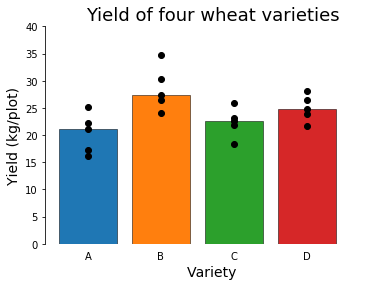

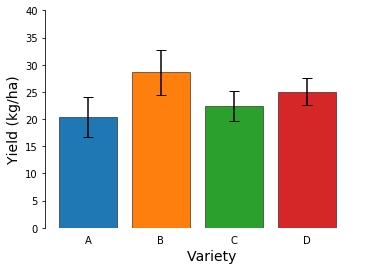

In [3]:
#plot data
fig, ax = plt.subplots()
pos = list(range(len(df)))
for i, col in enumerate(df.columns):
    ax.bar(pos[i], np.median(df[col]), zorder=3, edgecolor='k', linewidth=.5)
    for j in range(len(df[col])):
        ax.scatter(pos[i], df[col][j], c='k', zorder=4)
ax.set_xticks(pos)
ax.tick_params(axis='x', color='white')
ax.set_xticklabels(df.columns)
for position in ['top', 'right', 'bottom']:
    ax.spines[position].set_visible(False)
    
#calculate max of Series and set y-axis limit
ax.set_ylim(0, 40)

ax.set_ylabel('Yield (kg/plot)', fontsize=14)
ax.set_xlabel('Variety', fontsize=14)
ax.set_title('Yield of four wheat varieties', fontsize=18)
plt.show()

#plot the data with error bar
variances = df.var()
std_dev = np.sqrt(variances)
fig, ax = plt.subplots()
for i, col in enumerate(df.columns):
    ax.bar(pos[i], np.mean(df[col]), zorder=3, edgecolor='k', linewidth=.5)
    ax.errorbar(pos[i], np.mean(df[col]), std_dev[i], zorder=4, c='k', capsize=5)
ax.set_xticks(pos)
ax.tick_params(axis='x', color='white')
ax.set_xticklabels(df.columns)
for position in ['top', 'right', 'bottom']:
    ax.spines[position].set_visible(False)
ax.set_ylim(0, 40)
ax.set_xlabel('Variety', fontsize=14)
ax.set_ylabel('Yield (kg/ha)', fontsize=14)
plt.show()

## 3. Step-by-step calculations

The first step is to calculate a table showing the factor (variety) means and the corresponding variances, standard errors and $Sxx$ values. $Sxx$ is the sum of squares of the deviations from the sample mean, and is also equal to $(n - 1)s^2$ where $s^2$ is the sample variance and $n$ is the sample size.

In [4]:
#calculate means, variances, standard errors and Sxx
means = df.mean()
variances = df.var()
std_err = np.sqrt(variances / df.count())
std_dev = np.sqrt(variances)
Sxx = (df ** 2).sum() - df.sum() ** 2 / df.count()
tb = pd.concat([means, variances, std_err, Sxx], axis=1, keys=['Mean', 'Variance', 'Standard error', 'Sxx']).T
print(tb)

                        A         B          C          D
Mean            20.400000  28.60000  22.400000  25.000000
Variance        13.755000  16.96500   7.295000   6.085000
Standard error   1.658614   1.84201   1.207891   1.103177
Sxx             55.020000  67.86000  29.180000  24.340000


Second, we calculate the **total sum of squares** *TotalSS* which represents the **total variation**. It can be obtained by calculating the sum of squares of deviations from the *grand mean* (the mean over all samples combined) but more simply it is equal to: $$TotalSS = (N - 1)S^2$$ where $N$ is the sum of all sample sizes and $S^2$ the variance over all samples combined. 

The **factor sum of squares** *FactorSS* is an estimate of the factor (variety) effect and represents the **between-factor variation**. It is calculated with the sum of squares of deviations between *treatment means* and the *grand mean* or more easily with this formula: $$FactorSS = \sum(\frac{T^2}{r}) - \frac{G^2}{N}$$ with $T$ the factor (treatment) mean, $r$ the number of replication for a given factor, and G the grand total (the sum of all values).

The **residual sum of squares** *ResidSS* represents the **within-treatment variation**. It is sometimes called the **error sum of squares**. It is calculated by summing squares of deviations between individual values and their *factor mean*, or simply by subtracting *FactorSS* from *TotalSS*.

In [5]:
#calculate N (total number of values) and nb_t (number of factors)
N = len(df.values.flatten())
nb_t = len(df.columns)

#calculate total sum of squares
total_ss = df.values.flatten().var(ddof=1) * (df.size - 1)

#calculate factor sum of squares
factor_ss = sum(df.sum() ** 2 / df.count()) - (df.values.sum()) ** 2 / len(df.values.flatten())

#calculate residual sum of squares
resid_ss = total_ss - factor_ss

## 4. Analysis of variance

We test the null hypothesis that all treatments have the same effect on the yield. If all varieties have the same yield, the four sample means are all estimates of a common population mean. For the test to be valid, we assume that the observed yields for each variety are independent random samples from normally distributed populations each having the same variance $\sigma^2$. To test wheather means differ significantly between, the between-treatment variation is compared with the within-treatment variation. If *FactorSS* is greater than *ResidSS*, we suspect that this is due to real differences between factors of the experiment.

For each factor, the values are assumed to be a random sample of measurements taken from the hypothetical population of all possible measurements that could be obtained. Here we have four factors (varieties), so we have four hypothetical populations. If these populations have the same variance $\sigma^2$, called the **experimental error variance**, then the individual variance estimates $s_1^2$, $s_2^2$, $s_3^2$, $s_4^2$ can be pooled to give a more precise estimate of the experimental error. This pooled estimate of $\sigma^2$ is called $s_p^2$ and is a weighted average of the individual $s^2$ values, with the weights being the individual degrees of freedom: $$s_p^2 = \sum\limits_i\frac{(n_i - 1)s_i^2}{n_i - 1}$$
which is equal to summing $Sxx$ values for each sample, divided by the total number of degrees of freedom (total number of replicates N minus the number of factors t): $$s_p^2 = \frac{\sum Sxx}{N - t}$$
$s_p^2$ is a pooled estimate of the error variance $\sigma^2$. It is also called the **residual mean square** (*RMS*). 

In [6]:
#calculate the experimental error variance
resid_ms = Sxx.sum() / (N - nb_t)

Under the null hypothesis that all factors have the same effect, statistical theory shows that the sample variance of the factor means is an estimate of $\sigma^2/r$. Thus, we multiply it by r to obtain an estimate of $\sigma^2$ under the null hypothesis. This estimate is called the **factor mean square** denoted *FMS*. It can be calculated by finding the *FactorSS* and then dividing by $t - 1$, the number of factors minus 1. The factor mean square is an estimate of $\sigma^2$ under the null hypothesis of no treatment differences. $$FMS = \frac{FactorSS}{t - 1}$$

If there are factor differences the variation in the factor means will tend to be larger than expected under the null hypothesis and the *FMS* will tend to be an estimate of something larger than $\sigma^2$. Whether or not the null hypothesis is true, the within-treatment variation summarised by *RMS* is an estimate of $\sigma^2$. If the null hypothesis is true, similar values will be obtained for *RMS* and *FMS*. On the other hand, if factors have a different effect, *FMS* will be larger than *RMS*. To test the null hypothesis, the ratio of these two variance estimates is calculated. It is called the **variance ratio** and denoted by VR: $$VR = \frac{FMS}{RMS}$$
A value of $VR$ much larger than 1 provides evidence of different factor effects. To calculate a p-value, VR is compared with values of the F-distribution with $(t - 1, \thinspace N - t)$ degrees of freedom.

In [7]:
#calculate factor mean square
factor_ms = factor_ss / (nb_t - 1)

#calculate vr
vr = factor_ms / resid_ms

#calculate p-value
p_val = 1 - f.cdf(vr, nb_t - 1, N - nb_t)

In [8]:
print('Analysis of variance')
print('{0:10}{1:>10}{2:>10}{3:>10}{4:>10}{5:>10}'.format('Source', 'df', 'Sum sq', 'Mean sq', 'F-value', 'p-value'))
print('{0:10}{1:>10}{2:>10.2f}{3:>10.2f}{4:>10.3f}{5:>10.5f}'.format('Factor', nb_t - 1, factor_ss, factor_ms, vr, p_val))
print('{0:10}{1:>10}{2:>10.2f}{3:>10.2f}'.format('Error', N - nb_t, resid_ss, resid_ms))
print('{0:10}{1:>10}{2:>10.2f}'.format('Total', N - 1, total_ss))
print()
print('{0:5}{1:>10}{2:>10}{3:>10}'.format('Level', 'N', 'Mean', 'StDev'))
for i in range(nb_t):
    print('{0:5}{1:>10}{2:>10.3f}{3:>10.3f}'.format(df.columns[i], df.count().iloc[i], means[i], std_dev[i]))

Analysis of variance
Source            df    Sum sq   Mean sq   F-value   p-value
Factor             3    188.20     62.73     5.690   0.00756
Error             16    176.40     11.02
Total             19    364.60

Level         N      Mean     StDev
A             5    20.400     3.709
B             5    28.600     4.119
C             5    22.400     2.701
D             5    25.000     2.467


Finally, we calculate the **coefficient of variation** *CV*. Although *RMS* gives an estimate of residual variation, its size depends on the measurement unit. *CV* is a measure of the residual variation independent of the measurement unit, expressed in percent, and is calculated by dividing the square root of the residual mean square by the grand mean:
$$CV = \frac{\sqrt{RMS}}{GM}$$

In [9]:
#calculate coefficient of variation
gm = df.values.sum() / len(df.values.flatten()) #grand mean
cv = np.sqrt(resid_ms) / gm * 100

## 5. After ANOVA

The F-test in the analysis of variance is used to test whether there are any significant differences between the treatment means, it does not tell you where these differences lie. To compare individual varieties, we can perform a **least significant difference** (*LSD*) analysis. Concretely, it is equivalent to performing t-tests on every pairwise sample comparison. The reason is that for each comparison, we use the same **standard error of the difference** (*SED*) between the two means, which is calculated using the following formula: $$ SED = \sqrt{s_p^2\left(\frac{1}{n_1}+\frac{1}{n_2}\right)}$$
where $s_p^2$ is *RMS* from the ANOVA. Under the assumption of equal variance between samples, sample $s^2$ values are all estimators of the population variance $\sigma^2$. As the same *SED* value is used in all the tests, we can declare two sample means significantly different at the 5% level on a two-tailed test if: $$\frac{\bar{x_1}-\bar{x_2}}{SED} > t_{(N - t, \thinspace 2.5\%)}$$
In other words, two means are significantly different if their difference is greater than the **least significant difference level**: $$t_{(N - t, \thinspace 2.5\%)} \times SED$$

*LSD* analysis is controversial, some people say it should only be used for comparisons planned in advance, not for every sample comparison, and not for more than $N - t$ comparisons. Some people say *LSD* should not be carried out if the F-test on the ANOVA is not significant, and some people even say LSD should never be used. The problem is that is too many comparisons are performed, the likeliness of a false positive increases. In our example, the probability of a false positive with a single comparison is 0.05, but if all comparisons are made this increases to 0.184 and is called the family error rate. Methods exist to reduce the false positive rate when making multiple comparisons, for example Tukey's pairwise comparisons.

Another way to test for differences in means between samples is to perform Fisher's pairwise comparisons. This calculates all possible means differences and the 95 % confidence interval for the difference between two means. If zero is not in the confidence interval, the difference is statistically different. Fisher's pairwise comparisons are equivalent to LSD analysis, so the same warnings apply.

In [10]:
#LSD analysis between sample A and the other samples

#combination of samples
comb = list(combinations(df.columns, 2))[:nb_t - 1]

#dataframe to store lsd analysis
lsd_tb = pd.DataFrame(np.zeros((len(comb), 5)))

for i, c in enumerate(comb):
    dif_mean = means[c[0]] - means[c[1]]
    sed = np.sqrt(resid_ms * (1 / len(df[c[0]]) + 1 / len(df[c[1]])))
    t_val = dif_mean / sed
    lsd = t.ppf(0.975, df=N - nb_t) * sed
    p_val = 2 * (1 - t.cdf(abs(t_val), N - nb_t))
    
    lsd_tb.iloc[i, 0] = round(dif_mean, 3)
    lsd_tb.iloc[i, 1] = round(lsd, 3)
    lsd_tb.iloc[i, 2] = round(sed, 3)
    lsd_tb.iloc[i, 3] = round(t_val, 3)
    lsd_tb.iloc[i, 4] = round(p_val, 5)
    
lsd_tb.columns = ['Diff means', 'LSD', 'SED', 't_val', 'p-value']
lsd_tb.insert(0, 'Samples', comb)
lsd_tb = lsd_tb.set_index('Samples')
print(lsd_tb)

         Diff means    LSD  SED  t_val  p-value
Samples                                        
(A, B)         -8.2  4.452  2.1 -3.905  0.00126
(A, C)         -2.0  4.452  2.1 -0.952  0.35507
(A, D)         -4.6  4.452  2.1 -2.190  0.04364


### Confidence intervals

The 95 % confidence interval for the difference between two factor means is $difference \thinspace in \thinspace means \thinspace \pm \thinspace LSD_{5\%}$. For samples A and B, this is $8.2 \pm 4.445$. This confidence interval does not include zero, indicating the means of A and B are significantly different at the 5% level on a two-tailed test.

We can also calculate confidence interval for individual factor means. The pooled standard error for an individual factor level mean is $SEM = \sqrt{s_p^2/r}$ where $r$ is the number of replications for this level. A 95% confidence interval for a particular factor level mean is $mean \pm t_{(N \thinspace - \thinspace t, \thinspace 2.5\%)} \times SEM$. Let's calculate these values for our example.

In [25]:
#calculate standard error of the mean
sem = np.sqrt(resid_ms / df.count()[0])
print('Standard error of the mean : {:.3f}\n'.format(sem))

#calculate t(N-t, 2.5%)
crit = [t.ppf(0.025, N - nb_t), t.ppf(0.975, N - nb_t)]

#calculate confidence intervals
CI = [[mean + value * sem for value in crit] for mean in means]

for i, level in enumerate(means.index):
    print('Confidence interval for sample {0} : {1:.3f} - {2:.3f}'.format(level, CI[i][0], CI[i][1]))

Standard error of the mean : 1.485

Confidence interval for sample A : 17.252 - 23.548
Confidence interval for sample B : 25.452 - 31.748
Confidence interval for sample C : 19.252 - 25.548
Confidence interval for sample D : 21.852 - 28.148


In [40]:
#putting it all together
def anova(data, xlabel, ylabel, lsd=False):
    """Perform ANOVA on a pandas DataFrame where factors are present in colums and repetitions in rows. The argument lsd
    can be set to True to calculate the Least Significant Difference."""
    
    #calculate descriptive parameters
    means = data.mean()
    variances = data.var()
    std_err = np.sqrt(variances / data.count())
    std_dev = np.sqrt(variances)
    Sxx = (data ** 2).sum() - data.sum() ** 2 / data.count()
    
    #plot the data with error bar
    pos = list(range(len(data)))
    fig, ax = plt.subplots()
    for i, col in enumerate(data.columns):
        ax.bar(pos[i], np.mean(data[col]), zorder=3, edgecolor='k', linewidth=.5)
        ax.errorbar(pos[i], np.mean(data[col]), std_dev[i], zorder=4, c='k', capsize=5)
        
    #optimize figure style
    ax.set_xticks(pos)
    ax.tick_params(axis='x', color='white')
    ax.set_xticklabels(data.columns)
    for position in ['top', 'right', 'bottom']:
        ax.spines[position].set_visible(False)
        
    #adjust y-axis limits
    ax.set_ylim(0, round(max((data.values.flatten()) + max(std_dev)) / 5) * 5)
    
    #add axes label
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    plt.show()
    
    #calculate N (total number of values) and t (number of factors)
    N = len(data.values.flatten())
    nb_t = len(data.columns)

    #calculate total sum of squares
    total_ss = data.values.flatten().var(ddof=1) * (data.size - 1)

    #calculate factor sum of squares
    factor_ss = sum(data.sum() ** 2 / data.count()) - (data.values.sum()) ** 2 / N

    #calculate residual sum of squares
    resid_ss = total_ss - factor_ss
    
    #calculate the experimental error variance
    resid_ms = Sxx.sum() / (N - nb_t)
    
    #calculate factor mean square
    factor_ms = factor_ss / (nb_t - 1)

    #calculate vr
    vr = factor_ms / resid_ms

    #calculate p-value
    p_val = 1 - f.cdf(vr, nb_t - 1, N - nb_t)
    
    #calculate coefficient of variation
    gm = data.values.sum() / len(data.values.flatten()) #grand mean
    cv = np.sqrt(resid_ms) / gm * 100
    
    #print results
    print('Analysis of variance')
    print('{0:10}{1:>10}{2:>10}{3:>10}{4:>10}{5:>10}'.format('Source', 'df', 'Sum sq', 'Mean sq', 'F-value', 'p-value'))
    print('{0:10}{1:>10}{2:>10.2f}{3:>10.2f}{4:>10.3f}{5:>10.5f}'.format('Factor', nb_t - 1, factor_ss, factor_ms, vr, p_val))
    print('{0:10}{1:>10}{2:>10.2f}{3:>10.2f}'.format('Error', N - nb_t, resid_ss, resid_ms))
    print('{0:10}{1:>10}{2:>10.2f}'.format('Total', N - 1, total_ss))
    print()
    print('{0:5}{1:>10}{2:>10}{3:>10}'.format('Level', 'N', 'Mean', 'StDev'))
    for i in range(nb_t):
        print('{0:5}{1:>10}{2:>10.3f}{3:>10.3f}'.format(data.columns[i], data.count().iloc[i], means[i], std_dev[i]))
    print()
    print('Coefficient of variation : {:.2f}%'.format(cv))
    print()
    
    if lsd:
        #calculate sum of squares
        Sxx = (data ** 2).sum() - data.sum() ** 2 / data.count()
    
        #calculate N (total number of values) and nb_t (number of factors)
        N = len(data.values.flatten())
        nb_t = len(data.columns)

        #calculate the experimental error variance
        resid_ms = Sxx.sum() / (N - nb_t)

        #calculate standard error of the difference
        #assume same number of replications between factors
        sed = np.sqrt(2 * resid_ms / len(data[data.columns[0]]))

        #calculate least significant difference
        lsd = t.ppf(0.975, df=N - nb_t) * sed
        
        print('LSD : {:.3f}'.format(lsd))

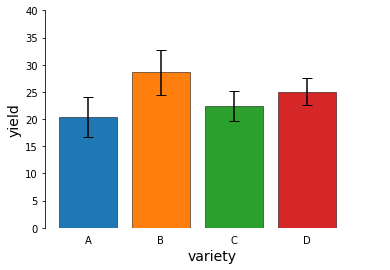

Analysis of variance
Source            df    Sum sq   Mean sq   F-value   p-value
Factor             3    188.20     62.73     5.690   0.00756
Error             16    176.40     11.02
Total             19    364.60

Level         N      Mean     StDev
A             5    20.400     3.709
B             5    28.600     4.119
C             5    22.400     2.701
D             5    25.000     2.467

Coefficient of variation : 13.78%



In [41]:
anova(df, 'variety', 'yield')

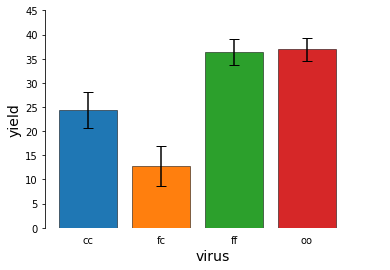

Analysis of variance
Source            df    Sum sq   Mean sq   F-value   p-value
Factor             3   1170.21    390.07    17.345   0.00073
Error              8    179.91     22.49
Total             11   1350.12

Level         N      Mean     StDev
cc            3    24.400     3.709
fc            3    12.867     4.119
ff            3    36.333     2.701
oo            3    36.900     2.467

Coefficient of variation : 17.17%

LSD : 8.929


In [42]:
df2 = pd.read_csv('potato.csv', index_col=0)
anova(df2, 'virus', 'yield', lsd=True)